# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Data Extraction and Cleaning

In [2]:
df = pd.read_csv('HealthCareAnalytics.csv')
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,patientid,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449,Nov-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056,31-40


## Fixing Label in stay column

In stay column, there is label written as "Nov-20",  but it actually should be a label with value "11-20"

In [3]:
df.replace("Nov-20","11-20",inplace=True)
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,patientid,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449,11-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056,31-40


## Check the labels in stay column

Based on the result in below, the data already converted to "11-20" value labels

In [4]:
df.iloc[:,-1].value_counts()

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

## Check the null value in other column

In [5]:
null_column = df.columns[df.isnull().any()]
df[null_column].isnull().sum()

Bed_Grade             113
City_Code_Patient    4532
dtype: int64

## Recheck the null value in stay column

There is no null value in stay column

In [6]:
stay_null = df[df["Stay"].isnull()][null_column]
print(stay_null)

Empty DataFrame
Columns: [Bed_Grade, City_Code_Patient]
Index: []


## Check the median value for Bed_Grade and City_Code_Patient column to replace the null value in those two columns

In [7]:
df.describe()

,case_id,Hospital_code,City_Code_Hospital,Available_Extra_Rooms_in_Hospital,Bed_Grade,patientid,City_Code_Patient,Visitors_with_Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,159219.500000,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,91925.276847,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,79610.250000,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,159219.500000,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,238828.750000,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,318438.000000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


Based on the result in above, the **median value in Bed_Grade column is 3** and **median value in City_Code_Patient is 8**

## Fill the Null Value

**Bed_Grade Column**

In [8]:
df['Bed_Grade'] = df['Bed_Grade'].fillna(df['Bed_Grade'].median())

**City_Code_Patient Column**

In [9]:
df['City_Code_Patient'] = df['City_Code_Patient'].fillna(df['City_Code_Patient'].median())

**Recheck the null value in the column**

In [10]:
null_column = df.columns[df.isnull().any()]
df[null_column].isnull().sum()

Series([], dtype: float64)

# 2. Data Preprocessing

## Removing Outliers

### Get IQR for each column

Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

QR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier.

Let’s find out we can box plot uses IQR and how we can use it to find the list of outliers as we did using Z-score calculation. First we will calculate IQR,

In [11]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
print(IQR)

case_id                              159218.5
Hospital_code                            15.0
City_Code_Hospital                        5.0
Available_Extra_Rooms_in_Hospital         2.0
Bed_Grade                                 1.0
patientid                             65623.0
City_Code_Patient                         4.0
Visitors_with_Patient                     2.0
Admission_Deposit                      1223.0
dtype: float64


As we now have the IQR scores, it’s time to get hold on outliers. The below code will give an output with some true and false values. The data point where we have False that means these values are valid whereas True indicates presence of an outlier.

In [12]:
(df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)) 

,Admission_Deposit,Age,Available_Extra_Rooms_in_Hospital,Bed_Grade,City_Code_Hospital,City_Code_Patient,Department,Hospital_code,Hospital_region_code,Hospital_type_code,Severity_of_Illness,Stay,Type_of_Admission,Visitors_with_Patient,Ward_Facility_Code,Ward_Type,case_id,patientid
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
318434,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
318435,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
318436,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Remove Outliers

**Before Remove the Outliers**

In [13]:
df.shape

(318438, 18)

In [14]:
df['Stay'].value_counts()

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

**After Remove the Outliers**

In [15]:
dfNoOutliers = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
dfNoOutliers.shape

(272804, 18)

## Duplicate the DataFrame for checking correlation heatmap

In [16]:
dfCopyNoOutliers = dfNoOutliers.copy()
dfCopyNoOutliers.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,patientid,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745,31-40
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449,11-20


## Label Encoding with Duplicated Dataframe

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

dfCopyNoOutliers.Hospital_type_code = le.fit_transform(dfCopyNoOutliers.Hospital_type_code)
dfCopyNoOutliers.Hospital_region_code = le.fit_transform(dfCopyNoOutliers.Hospital_region_code)
dfCopyNoOutliers.Department = le.fit_transform(dfCopyNoOutliers.Department)
dfCopyNoOutliers.Ward_Type = le.fit_transform(dfCopyNoOutliers.Ward_Type)
dfCopyNoOutliers.Ward_Facility_Code = le.fit_transform(dfCopyNoOutliers.Ward_Facility_Code)
dfCopyNoOutliers.Type_of_Admission = le.fit_transform(dfCopyNoOutliers.Type_of_Admission)
dfCopyNoOutliers.Severity_of_Illness = le.fit_transform(dfCopyNoOutliers.Severity_of_Illness)
dfCopyNoOutliers.Age = le.fit_transform(dfCopyNoOutliers.Age)
dfCopyNoOutliers.Stay = le.fit_transform(dfCopyNoOutliers.Stay)

## Check Correlation Heatmap for the feature to Labels (Stay)

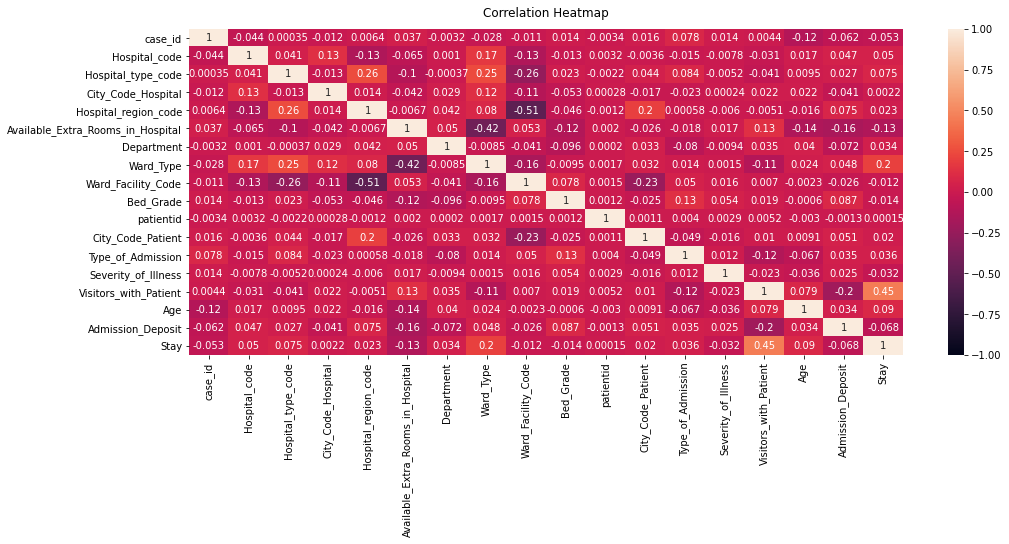

In [18]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(dfCopyNoOutliers.corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Based on correlation heatmap in above, the lowest collinearity features to the target is **City_Code_Hospital, patiendid** . Because of that, we decide to delete those column due to effectivity the learning of machine learning model

## Delete Unused Data Column

In [19]:
dfNoOutliers = dfNoOutliers.drop(['City_Code_Hospital','patientid'], axis=1)

In [20]:
dfNoOutliers

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,c,Z,3,radiotherapy,R,F,2.0,7.0,Emergency,Extreme,2,51-60,4911,0-10
1,2,2,c,Z,2,radiotherapy,S,F,2.0,7.0,Trauma,Extreme,2,51-60,5954,41-50
2,3,10,e,X,2,anesthesia,S,E,2.0,7.0,Trauma,Extreme,2,51-60,4745,31-40
4,5,26,b,Y,2,radiotherapy,S,D,2.0,7.0,Trauma,Extreme,2,51-60,5558,41-50
5,6,23,a,X,2,anesthesia,S,F,2.0,7.0,Trauma,Extreme,2,51-60,4449,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318431,318432,23,a,X,3,anesthesia,Q,F,4.0,2.0,Urgent,Extreme,2,71-80,4508,11-20
318434,318435,24,a,X,2,anesthesia,Q,E,4.0,8.0,Urgent,Moderate,4,81-90,6699,31-40
318435,318436,7,a,X,3,gynecology,R,F,4.0,10.0,Emergency,Minor,3,71-80,4235,11-20
318436,318437,11,b,Y,3,anesthesia,Q,D,3.0,8.0,Trauma,Minor,5,11-20,3761,11-20


In [21]:
dfNoOutliers.to_csv('dfNoOutliers.csv',index=False)

## Label Encoding for Original Dataframe (dfNoOutliers)

In [22]:
dfNoOutliers.Hospital_type_code = le.fit_transform(dfNoOutliers.Hospital_type_code)
dfNoOutliers.Hospital_region_code = le.fit_transform(dfNoOutliers.Hospital_region_code)
dfNoOutliers.Department = le.fit_transform(dfNoOutliers.Department)
dfNoOutliers.Ward_Type = le.fit_transform(dfNoOutliers.Ward_Type)
dfNoOutliers.Ward_Facility_Code = le.fit_transform(dfNoOutliers.Ward_Facility_Code)
dfNoOutliers.Type_of_Admission = le.fit_transform(dfNoOutliers.Type_of_Admission)
dfNoOutliers.Severity_of_Illness = le.fit_transform(dfNoOutliers.Severity_of_Illness)
dfNoOutliers.Age = le.fit_transform(dfNoOutliers.Age)

In [23]:
dfNoOutliers.head(10)

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,2,2,3,3,2,5,2.0,7.0,0,0,2,5,4911,0-10
1,2,2,2,2,2,3,3,5,2.0,7.0,1,0,2,5,5954,41-50
2,3,10,4,0,2,1,3,4,2.0,7.0,1,0,2,5,4745,31-40
4,5,26,1,1,2,3,3,3,2.0,7.0,1,0,2,5,5558,41-50
5,6,23,0,0,2,1,3,5,2.0,7.0,1,0,2,5,4449,11-20
6,7,32,5,1,1,3,3,1,3.0,7.0,0,0,2,5,6167,0-10
7,8,23,0,0,4,3,1,5,3.0,7.0,1,0,2,5,5571,41-50
8,9,1,3,1,2,2,2,1,4.0,7.0,1,0,2,5,7223,51-60
9,10,10,4,0,2,2,3,4,3.0,7.0,1,0,2,5,6056,31-40
10,11,22,6,1,2,3,3,1,2.0,7.0,2,0,2,5,5797,21-30


In [24]:
dfNoOutliers['Severity_of_Illness'].value_counts()

2    150919
1     73004
0     48881
Name: Severity_of_Illness, dtype: int64

## Split DataFrame

In [36]:
dfNoOutliers['Stay'].value_counts()

21-30                 77181
11-20                 69090
31-40                 47764
51-60                 29482
0-10                  20705
41-50                 10075
71-80                  7863
81-90                  3387
More than 100 Days     3061
61-70                  2219
91-100                 1977
Name: Stay, dtype: int64

Based on the total distribution labels in above, I will split the dataframe and group it based on 4 range of Duration Day of Stay in the hospital :


1.   **OneMonth = 0-30 Days**
2.   **TwoMonth = 31-60 Days**
3.   **ThreeMonth = 61-90 Days**
4.   **TwoMonth = 91-More than 100 Days**



#### **OneMonth Dataframe (0-30 Days)**

In [38]:
OneMonthDF = dfNoOutliers.loc[(dfNoOutliers['Stay']=="0-10") |
                               (dfNoOutliers['Stay']=="11-20") |
                               (dfNoOutliers['Stay']=="21-30")
                             ]

In [39]:
OneMonthDF

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
0,1,8,2,2,3,3,2,5,2.0,7.0,0,0,2,5,4911,0-10
5,6,23,0,0,2,1,3,5,2.0,7.0,1,0,2,5,4449,11-20
6,7,32,5,1,1,3,3,1,3.0,7.0,0,0,2,5,6167,0-10
10,11,22,6,1,2,3,3,1,2.0,7.0,2,0,2,5,5797,21-30
11,12,26,1,1,4,3,2,3,1.0,7.0,2,0,2,5,5993,11-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318430,318431,6,0,0,3,1,1,5,4.0,8.0,1,2,2,4,5065,21-30
318431,318432,23,0,0,3,1,1,5,4.0,2.0,2,0,2,7,4508,11-20
318435,318436,7,0,0,3,2,2,5,4.0,10.0,0,1,3,7,4235,11-20
318436,318437,11,1,1,3,1,1,3,3.0,8.0,1,1,5,1,3761,11-20


#### **TwoMonth Dataframe (31-60 Days)**

In [40]:
TwoMonthDF = dfNoOutliers.loc[(dfNoOutliers['Stay']=="31-40") |
                               (dfNoOutliers['Stay']=="41-50") |
                               (dfNoOutliers['Stay']=="51-60")
                             ]

In [41]:
TwoMonthDF

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
1,2,2,2,2,2,3,3,5,2.0,7.0,1,0,2,5,5954,41-50
2,3,10,4,0,2,1,3,4,2.0,7.0,1,0,2,5,4745,31-40
4,5,26,1,1,2,3,3,3,2.0,7.0,1,0,2,5,5558,41-50
7,8,23,0,0,4,3,1,5,3.0,7.0,1,0,2,5,5571,41-50
8,9,1,3,1,2,2,2,1,4.0,7.0,1,0,2,5,7223,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318406,318407,28,1,0,4,2,2,5,4.0,1.0,1,2,5,7,4434,51-60
318408,318409,22,6,1,2,2,3,1,2.0,8.0,1,2,2,1,3930,51-60
318419,318420,16,2,2,1,2,3,0,4.0,6.0,1,2,2,4,4339,31-40
318427,318428,20,1,1,2,0,3,3,3.0,5.0,2,1,4,5,4271,31-40


#### **ThreeMonth Dataframe (61-90 Days)**

In [42]:
ThreeMonthDF = dfNoOutliers.loc[(dfNoOutliers['Stay']=="61-70") |
                              (dfNoOutliers['Stay']=="71-80") |
                              (dfNoOutliers['Stay']=="81-90") 
                               ]

In [43]:
ThreeMonthDF

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
39,40,19,0,1,2,3,3,2,3.0,7.0,0,1,4,7,4718,71-80
76,77,14,0,0,2,1,3,4,4.0,3.0,1,2,4,6,4204,71-80
176,177,14,0,0,2,1,3,4,1.0,9.0,1,0,4,5,3225,71-80
183,184,23,0,0,3,1,2,5,3.0,8.0,1,2,2,7,3760,71-80
204,205,24,0,0,3,2,2,4,2.0,1.0,1,2,5,4,5178,71-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318013,318014,28,1,0,2,0,2,5,2.0,8.0,0,2,3,6,5883,61-70
318047,318048,23,0,0,5,2,3,5,3.0,8.0,0,2,4,8,3876,71-80
318072,318073,26,1,1,4,1,2,3,2.0,8.0,2,2,6,4,4659,71-80
318086,318087,31,2,2,2,2,2,0,3.0,5.0,0,1,5,6,4496,71-80


#### **MoreThanThreeMonth Dataframe (91-More than 100 Days)**

In [44]:
MoreThanThreeMonthDF = dfNoOutliers.loc[(dfNoOutliers['Stay']=="91-100") |
                              (dfNoOutliers['Stay']=="More than 100 Days") 
                               ]

In [45]:
MoreThanThreeMonthDF

,case_id,Hospital_code,Hospital_type_code,Hospital_region_code,Available_Extra_Rooms_in_Hospital,Department,Ward_Type,Ward_Facility_Code,Bed_Grade,City_Code_Patient,Type_of_Admission,Severity_of_Illness,Visitors_with_Patient,Age,Admission_Deposit,Stay
45,46,19,0,1,3,2,3,2,3.0,8.0,0,2,6,3,4046,More than 100 Days
281,282,26,1,1,3,2,2,3,1.0,9.0,0,0,5,7,4778,More than 100 Days
283,284,26,1,1,5,2,2,3,1.0,9.0,1,0,6,7,7165,More than 100 Days
316,317,23,0,0,3,1,2,5,3.0,8.0,1,0,4,5,4116,91-100
425,426,32,5,1,2,2,3,1,3.0,1.0,1,2,6,6,3919,More than 100 Days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317432,317433,26,1,1,3,3,3,3,1.0,8.0,2,0,6,6,3834,More than 100 Days
318097,318098,6,0,0,2,2,2,5,3.0,7.0,2,2,2,4,4530,91-100
318277,318278,26,1,1,3,1,3,3,4.0,2.0,2,1,5,4,4306,More than 100 Days
318325,318326,11,1,1,3,2,3,3,4.0,14.0,0,1,4,3,3470,More than 100 Days


# **Machine Learning with OneMonthDF**

## Split Data

In [46]:
OneMonthDF.shape

(166976, 16)

Split data are used to split the original data into 2 different parts which is training data and testing data. Training data will also be divided into 2 parts training data and validation training data. This process to ensure when the model being trained we have a data to validate the predicted output of a model.

In [48]:
OneMonth_input_data = OneMonthDF.iloc[:, :-1]
OneMonth_output_data = OneMonthDF['Stay']

We divided the data into 4 parts:
- X_train is a training data that have no output.
- X_test is a testing data that have no output. This data will be use by the model to predict the output of the X_test data
- y_train is a training data that has the output data from X_train data.
- y_test is the original output data from X_test. This data will be used to validate the accuracy of predicted data that were generated by the model.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(OneMonth_input_data, OneMonth_output_data, test_size=0.3, random_state=10)

## Scale Data

Here we transform the data to fit within a specific scale using these algorithms a change of "1" in any numeric feature will give the same importance to each data. We used StandardScaler() method from Sklearn library. Define the transformation for train and test data:
- X_train will be scale using fit_transform()
- X_test will be scale using transform()

In [50]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Resample Data to Fix Imbalanced Data

**Before Resample Data**

In [55]:
y_train.value_counts()

21-30    53983
11-20    48471
0-10     14429
Name: Stay, dtype: int64

**After Resample Data**

In [53]:
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=0)

#transform the dataset
OneMonth_smotetomek_X, OneMonth_smotetomek_Y = smotetomek.fit_resample(X_train_scaled, y_train)
#check the data y_train
pd.DataFrame(OneMonth_smotetomek_Y).value_counts()

0-10     53109
21-30    45566
11-20    45526
dtype: int64

## Create Machine Learning Model with XGBoost Default Parameter

In [56]:
OneMonth_model = XGBClassifier()

## Train the model

In [57]:
OneMonth_model.fit(OneMonth_smotetomek_X, OneMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predict Model using Test Data

In [58]:
y_pred = OneMonth_model.predict(X_test_scaled.values)

### Before evaluation we need to know the value count of each class from the original output data

Here are the count of 'no' data and the count of 'yes' data from the original output data

In [59]:
y_test.value_counts()

21-30    23198
11-20    20619
0-10      6276
Name: Stay, dtype: int64

## Evaluation Metrics using Confusion Matrix

In [60]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  0-10  11-20  21-30
Stay                     
0-10   2607   2106   1563
11-20  3648  11130   5841
21-30  2910   8059  12229


**Get the Confusion Matrix**

In [61]:
! pip install -q scikit-plot

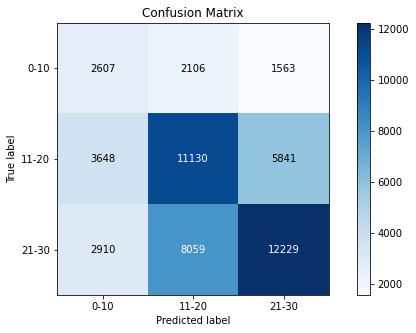

In [63]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(10,5))

## Evaluation Metrics using Classification Report

Here we used the classification report from sklearn library in the classification report function we have precision, recall, f1-score and support for the evaluation metrics.

## Precision

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.

## Recall

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

## F1-Score

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

## Support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        0-10       0.28      0.42      0.34      6276
       11-20       0.52      0.54      0.53     20619
       21-30       0.62      0.53      0.57     23198

    accuracy                           0.52     50093
   macro avg       0.48      0.49      0.48     50093
weighted avg       0.54      0.52      0.53     50093



## Hyperparameterized XGBoost

### RandomizedSearch CV for Best Parameters

In [65]:
parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [66]:
OneMonthRSCV_model = RandomizedSearchCV(XGBClassifier(), param_distributions = parameters,verbose=2)

OneMonthRSCV_model.fit(OneMonth_smotetomek_X, OneMonth_smotetomek_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7, total= 1.2min
[CV] min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7, total= 1.1min
[CV] min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7, total= 1.1min
[CV] min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7, total= 1.1min
[CV] min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7 
[CV]  min_child_weight=5, max_depth=10, learning_rate=0.25, gamma=0.1, colsample_bytree=0.7, total= 1.1min
[CV] min_child_weight=5, max_depth=15, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[CV]  min_child_weight=5, max_depth=15, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4, total= 1.5min
[CV] min_child_weight=5, max_depth=15, learning_rate=0.1, gamma=0.4, colsample_bytree=0.4 
[CV]  mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 40.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [67]:
OneMonthRSCV_model.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 5}

The Best Parameter for XGBoostClassifier is {'colsample_bytree': 0.4,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 5}

### Input Best Parameter into XGBoost Classifier

In [68]:
OneMonth_model_best = XGBClassifier(colsample_bytree=0.4,gamma=0.4,learning_rate=0.1,max_depth=15,min_child_weight=5)

### Re-Train the XGBoost Classifier Model

In [69]:
OneMonth_model_best.fit(OneMonth_smotetomek_X, OneMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Re-predict the Model using Test Data

In [70]:
y_pred = OneMonth_model_best.predict(X_test_scaled.values)

### Re-evaluation

#### Confusion Matrix

**Confusion Matrix After Hyperparameterized Tuning**

In [71]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  0-10  11-20  21-30
Stay                     
0-10   1308   2885   2083
11-20  1089  11705   7825
21-30   740   7183  15275


**Confusion Matrix Before Hyperparameterized Tuning**

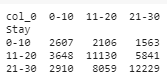

#### Classification Report

**Classification Report After Hyperparameterized Tuning**

In [72]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        0-10       0.42      0.21      0.28      6276
       11-20       0.54      0.57      0.55     20619
       21-30       0.61      0.66      0.63     23198

    accuracy                           0.56     50093
   macro avg       0.52      0.48      0.49     50093
weighted avg       0.55      0.56      0.55     50093



**Classification Report Before Hyperparameterized Tuning**

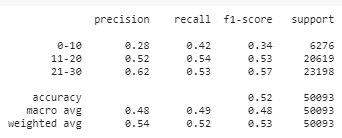

# **Machine Learning with TwoMonthDF**

## Split Data

In [73]:
TwoMonthDF.shape

(87321, 16)

Split data are used to split the original data into 2 different parts which is training data and testing data. Training data will also be divided into 2 parts training data and validation training data. This process to ensure when the model being trained we have a data to validate the predicted output of a model.

In [74]:
TwoMonth_input_data = TwoMonthDF.iloc[:, :-1]
TwoMonth_output_data = TwoMonthDF['Stay']

We divided the data into 4 parts:
- X_train is a training data that have no output.
- X_test is a testing data that have no output. This data will be use by the model to predict the output of the X_test data
- y_train is a training data that has the output data from X_train data.
- y_test is the original output data from X_test. This data will be used to validate the accuracy of predicted data that were generated by the model.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(TwoMonth_input_data, TwoMonth_output_data, test_size=0.3, random_state=10)

## Scale Data

Here we transform the data to fit within a specific scale using these algorithms a change of "1" in any numeric feature will give the same importance to each data. We used StandardScaler() method from Sklearn library. Define the transformation for train and test data:
- X_train will be scale using fit_transform()
- X_test will be scale using transform()

In [76]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Resample Data to Fix Imbalanced Data

**Before Resample Data**

In [77]:
y_train.value_counts()

31-40    33474
51-60    20651
41-50     6999
Name: Stay, dtype: int64

**After Resample Data**

In [78]:
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=0)

#transform the dataset
TwoMonth_smotetomek_X, TwoMonth_smotetomek_Y = smotetomek.fit_resample(X_train_scaled, y_train)
#check the data y_train
pd.DataFrame(TwoMonth_smotetomek_Y).value_counts()

41-50    33249
51-60    31522
31-40    31369
dtype: int64

## Create Machine Learning Model with XGBoost Default Parameter

In [79]:
TwoMonth_model = XGBClassifier()

## Train the model

In [80]:
TwoMonth_model.fit(TwoMonth_smotetomek_X, TwoMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predict Model using Test Data

In [81]:
y_pred = TwoMonth_model.predict(X_test_scaled.values)

### Before evaluation we need to know the value count of each class from the original output data

Here are the count of 'no' data and the count of 'yes' data from the original output data

In [82]:
y_test.value_counts()

31-40    14290
51-60     8831
41-50     3076
Name: Stay, dtype: int64

## Evaluation Metrics using Confusion Matrix

In [83]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  31-40  41-50  51-60
Stay                      
31-40   9038    847   4405
41-50   2388    365    323
51-60   2722    152   5957


**Get the Confusion Matrix**

In [84]:
! pip install -q scikit-plot

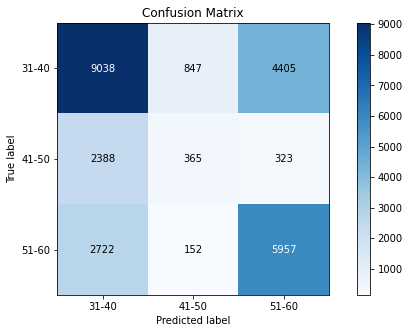

In [85]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(10,5))

## Evaluation Metrics using Classification Report

Here we used the classification report from sklearn library in the classification report function we have precision, recall, f1-score and support for the evaluation metrics.

## Precision

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.

## Recall

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

## F1-Score

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

## Support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       31-40       0.64      0.63      0.64     14290
       41-50       0.27      0.12      0.16      3076
       51-60       0.56      0.67      0.61      8831

    accuracy                           0.59     26197
   macro avg       0.49      0.48      0.47     26197
weighted avg       0.57      0.59      0.57     26197



## Hyperparameterized XGBoost

### RandomizedSearch CV for Best Parameters

In [87]:
parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [88]:
TwoMonthRSCV_model = RandomizedSearchCV(XGBClassifier(), param_distributions = parameters,verbose=2)

TwoMonthRSCV_model.fit(TwoMonth_smotetomek_X, TwoMonth_smotetomek_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4, total=  56.9s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s


[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4, total=  54.7s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4 
[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4, total=  54.7s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4 
[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4, total=  53.8s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4 
[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.3, colsample_bytree=0.4, total=  53.8s
[CV] min_child_weight=5, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3 
[CV]  min_child_weight=5, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3, total=  34.2s
[CV] min_child_weight=5, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3 
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 35.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [89]:
TwoMonthRSCV_model.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.25,
 'max_depth': 15,
 'min_child_weight': 5}

The Best Parameter for XGBoostClassifier is {'colsample_bytree': 0.7,
 'gamma': 0.3,
 'learning_rate': 0.25,
 'max_depth': 15,
 'min_child_weight': 5}

### Input Best Parameter into XGBoost Classifier

In [90]:
TwoMonth_model_best = XGBClassifier(colsample_bytree=0.7,gamma=0.3,learning_rate=0.25,max_depth=15,min_child_weight=5)

### Re-Train the XGBoost Classifier Model

In [92]:
TwoMonth_model_best.fit(TwoMonth_smotetomek_X, TwoMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
              learning_rate=0.25, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Re-predict the Model using Test Data

In [93]:
y_pred = TwoMonth_model_best.predict(X_test_scaled.values)

### Re-evaluation

#### Confusion Matrix

**Confusion Matrix After Hyperparameterized Tuning**

In [94]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  31-40  41-50  51-60
Stay                      
31-40  11223    410   2657
41-50   2550    215    311
51-60   4045    100   4686


**Confusion Matrix Before Hyperparameterized Tuning**

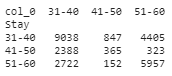

#### Classification Report

**Classification Report After Hyperparameterized Tuning**

In [95]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       31-40       0.63      0.79      0.70     14290
       41-50       0.30      0.07      0.11      3076
       51-60       0.61      0.53      0.57      8831

    accuracy                           0.62     26197
   macro avg       0.51      0.46      0.46     26197
weighted avg       0.58      0.62      0.59     26197



**Classification Report Before Hyperparameterized Tuning**

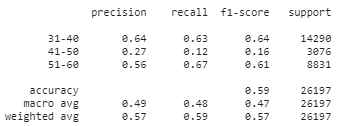

# **Machine Learning with ThreeMonthDF**

## Split Data

In [96]:
ThreeMonthDF.shape

(13469, 16)

Split data are used to split the original data into 2 different parts which is training data and testing data. Training data will also be divided into 2 parts training data and validation training data. This process to ensure when the model being trained we have a data to validate the predicted output of a model.

In [97]:
ThreeMonth_input_data = ThreeMonthDF.iloc[:, :-1]
ThreeMonth_output_data = ThreeMonthDF['Stay']

We divided the data into 4 parts:
- X_train is a training data that have no output.
- X_test is a testing data that have no output. This data will be use by the model to predict the output of the X_test data
- y_train is a training data that has the output data from X_train data.
- y_test is the original output data from X_test. This data will be used to validate the accuracy of predicted data that were generated by the model.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(ThreeMonth_input_data, ThreeMonth_output_data, test_size=0.3, random_state=10)

## Scale Data

Here we transform the data to fit within a specific scale using these algorithms a change of "1" in any numeric feature will give the same importance to each data. We used StandardScaler() method from Sklearn library. Define the transformation for train and test data:
- X_train will be scale using fit_transform()
- X_test will be scale using transform()

In [99]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Resample Data to Fix Imbalanced Data

**Before Resample Data**

In [100]:
y_train.value_counts()

71-80    5522
81-90    2371
61-70    1535
Name: Stay, dtype: int64

**After Resample Data**

In [101]:
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=0)

#transform the dataset
ThreeMonth_smotetomek_X, ThreeMonth_smotetomek_Y = smotetomek.fit_resample(X_train_scaled, y_train)
#check the data y_train
pd.DataFrame(ThreeMonth_smotetomek_Y).value_counts()

61-70    5498
81-90    5433
71-80    5415
dtype: int64

## Create Machine Learning Model with XGBoost Default Parameter

In [102]:
ThreeMonth_model = XGBClassifier()

## Train the model

In [103]:
ThreeMonth_model.fit(ThreeMonth_smotetomek_X, ThreeMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predict Model using Test Data

In [104]:
y_pred = ThreeMonth_model.predict(X_test_scaled.values)

### Before evaluation we need to know the value count of each class from the original output data

Here are the count of 'no' data and the count of 'yes' data from the original output data

In [105]:
y_test.value_counts()

71-80    2341
81-90    1016
61-70     684
Name: Stay, dtype: int64

## Evaluation Metrics using Confusion Matrix

In [106]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  61-70  71-80  81-90
Stay                      
61-70    401    230     53
71-80    248   1870    223
81-90     63    243    710


**Get the Confusion Matrix**

In [107]:
! pip install -q scikit-plot

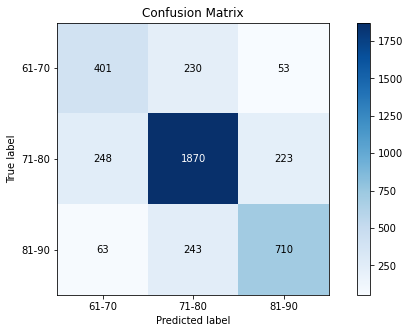

In [108]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(10,5))

## Evaluation Metrics using Classification Report

Here we used the classification report from sklearn library in the classification report function we have precision, recall, f1-score and support for the evaluation metrics.

## Precision

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.

## Recall

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

## F1-Score

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

## Support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       61-70       0.56      0.59      0.57       684
       71-80       0.80      0.80      0.80      2341
       81-90       0.72      0.70      0.71      1016

    accuracy                           0.74      4041
   macro avg       0.69      0.69      0.69      4041
weighted avg       0.74      0.74      0.74      4041



## Hyperparameterized XGBoost

### RandomizedSearch CV for Best Parameters

In [110]:
parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [111]:
ThreeMonthRSCV_model = RandomizedSearchCV(XGBClassifier(), param_distributions = parameters,verbose=2)

ThreeMonthRSCV_model.fit(ThreeMonth_smotetomek_X, ThreeMonth_smotetomek_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4, total=   4.9s
[CV] min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4, total=   4.7s
[CV] min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4 
[CV]  min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4, total=   4.6s
[CV] min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4 
[CV]  min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4, total=   4.6s
[CV] min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4 
[CV]  min_child_weight=7, max_depth=8, learning_rate=0.1, gamma=0.1, colsample_bytree=0.4, total=   4.6s
[CV] min_child_weight=7, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3 
[CV]  min_child_weight=7, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3, total=   5.5s
[CV] min_child_weight=7, max_depth=12, learning_rate=0.15, gamma=0.3, colsample_bytree=0.3 
[CV]  min_child_wei

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [112]:
ThreeMonthRSCV_model.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 3}

The Best Parameter for XGBoostClassifier is {'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 3}

### Input Best Parameter into XGBoost Classifier

In [113]:
ThreeMonth_model_best = XGBClassifier(colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,max_depth=15,min_child_weight=3)

### Re-Train the XGBoost Classifier Model

In [114]:
ThreeMonth_model_best.fit(ThreeMonth_smotetomek_X, ThreeMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Re-predict the Model using Test Data

In [115]:
y_pred = ThreeMonth_model_best.predict(X_test_scaled.values)

### Re-evaluation

#### Confusion Matrix

**Confusion Matrix After Hyperparameterized Tuning**

In [116]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0  61-70  71-80  81-90
Stay                      
61-70    351    285     48
71-80    169   2017    155
81-90     43    308    665


**Confusion Matrix Before Hyperparameterized Tuning**

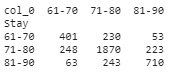

#### Classification Report

**Classification Report After Hyperparameterized Tuning**

In [117]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       61-70       0.62      0.51      0.56       684
       71-80       0.77      0.86      0.81      2341
       81-90       0.77      0.65      0.71      1016

    accuracy                           0.75      4041
   macro avg       0.72      0.68      0.69      4041
weighted avg       0.75      0.75      0.74      4041



**Classification Report Before Hyperparameterized Tuning**

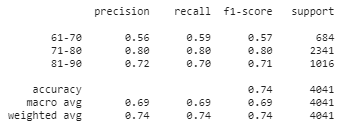

# **Machine Learning with MoreThanThreeMonthDF**

## Split Data

In [119]:
MoreThanThreeMonthDF.shape

(5038, 16)

Split data are used to split the original data into 2 different parts which is training data and testing data. Training data will also be divided into 2 parts training data and validation training data. This process to ensure when the model being trained we have a data to validate the predicted output of a model.

In [120]:
MoreThanThreeMonth_input_data = MoreThanThreeMonthDF.iloc[:, :-1]
MoreThanThreeMonth_output_data = MoreThanThreeMonthDF['Stay']

We divided the data into 4 parts:
- X_train is a training data that have no output.
- X_test is a testing data that have no output. This data will be use by the model to predict the output of the X_test data
- y_train is a training data that has the output data from X_train data.
- y_test is the original output data from X_test. This data will be used to validate the accuracy of predicted data that were generated by the model.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(MoreThanThreeMonth_input_data, MoreThanThreeMonth_output_data, test_size=0.3, random_state=10)

## Scale Data

Here we transform the data to fit within a specific scale using these algorithms a change of "1" in any numeric feature will give the same importance to each data. We used StandardScaler() method from Sklearn library. Define the transformation for train and test data:
- X_train will be scale using fit_transform()
- X_test will be scale using transform()

In [122]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

## Resample Data to Fix Imbalanced Data

**Before Resample Data**

In [123]:
y_train.value_counts()

More than 100 Days    2140
91-100                1386
Name: Stay, dtype: int64

**After Resample Data**

In [124]:
from imblearn.combine import SMOTETomek

smotetomek = SMOTETomek(random_state=0)

#transform the dataset
MoreThanThreeMonth_smotetomek_X, MoreThanThreeMonth_smotetomek_Y = smotetomek.fit_resample(X_train_scaled, y_train)
#check the data y_train
pd.DataFrame(MoreThanThreeMonth_smotetomek_Y).value_counts()

More than 100 Days    2008
91-100                2008
dtype: int64

## Create Machine Learning Model with XGBoost Default Parameter

In [125]:
MoreThanThreeMonth_model = XGBClassifier()

## Train the model

In [126]:
MoreThanThreeMonth_model.fit(MoreThanThreeMonth_smotetomek_X, MoreThanThreeMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Predict Model using Test Data

In [127]:
y_pred = MoreThanThreeMonth_model.predict(X_test_scaled.values)

### Before evaluation we need to know the value count of each class from the original output data

Here are the count of 'no' data and the count of 'yes' data from the original output data

In [128]:
y_test.value_counts()

More than 100 Days    921
91-100                591
Name: Stay, dtype: int64

## Evaluation Metrics using Confusion Matrix

In [129]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0               91-100  More than 100 Days
Stay                                          
91-100                 446                 145
More than 100 Days     283                 638


**Get the Confusion Matrix**

In [130]:
! pip install -q scikit-plot

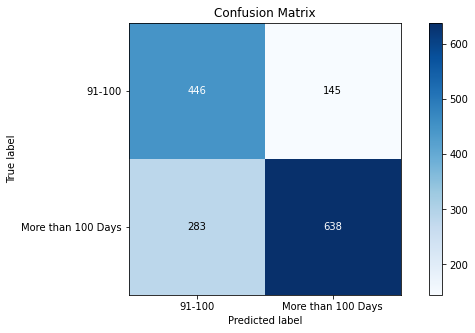

In [131]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(10,5))

## Evaluation Metrics using Classification Report

Here we used the classification report from sklearn library in the classification report function we have precision, recall, f1-score and support for the evaluation metrics.

## Precision

Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class, it is defined as the ratio of true positives to the sum of a true positive and false positive.

## Recall

Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.

## F1-Score

The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

## Support

Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

In [132]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

            91-100       0.61      0.75      0.68       591
More than 100 Days       0.81      0.69      0.75       921

          accuracy                           0.72      1512
         macro avg       0.71      0.72      0.71      1512
      weighted avg       0.74      0.72      0.72      1512



## Hyperparameterized XGBoost

### RandomizedSearch CV for Best Parameters

In [133]:
parameters = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [134]:
MoreThanThreeMonthRSCV_model = RandomizedSearchCV(XGBClassifier(), param_distributions = parameters,verbose=2)

MoreThanThreeMonthRSCV_model.fit(MoreThanThreeMonth_smotetomek_X, MoreThanThreeMonth_smotetomek_Y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3, total=   0.2s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3, total=   0.2s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3 
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3, total=   0.2s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3 
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3, total=   0.2s
[CV] min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3 
[CV]  min_child_weight=3, max_depth=5, learning_rate=0.3, gamma=0.2, colsample_bytree=0.3, total=   0.2s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.0, colsample_bytree=0.5 
[CV]  min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.0, colsample_bytree=0.5, total=   0.7s
[CV] min_child_weight=1, max_depth=15, learning_rate=0.25, gamma=0.0, colsample_bytree=0.5 
[CV]  min_child_wei

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   23.5s finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [135]:
MoreThanThreeMonthRSCV_model.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3}

The Best Parameter for XGBoostClassifier is {'colsample_bytree': 0.5,
 'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 3}

### Input Best Parameter into XGBoost Classifier

In [136]:
MoreThanThreeMonth_model_best = XGBClassifier(colsample_bytree=0.5,gamma=0.3,learning_rate=0.1,max_depth=12,min_child_weight=3)

### Re-Train the XGBoost Classifier Model

In [137]:
MoreThanThreeMonth_model_best.fit(MoreThanThreeMonth_smotetomek_X, MoreThanThreeMonth_smotetomek_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Re-predict the Model using Test Data

In [138]:
y_pred = MoreThanThreeMonth_model_best.predict(X_test_scaled.values)

### Re-evaluation

#### Confusion Matrix

**Confusion Matrix After Hyperparameterized Tuning**

In [139]:
confusion_matrix = pd.crosstab(y_test, y_pred)
print (confusion_matrix)

col_0               91-100  More than 100 Days
Stay                                          
91-100                 370                 221
More than 100 Days     210                 711


**Confusion Matrix Before Hyperparameterized Tuning**

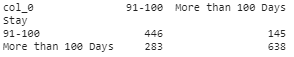

#### Classification Report

**Classification Report After Hyperparameterized Tuning**

In [140]:
print(classification_report(y_test,y_pred))

                    precision    recall  f1-score   support

            91-100       0.64      0.63      0.63       591
More than 100 Days       0.76      0.77      0.77       921

          accuracy                           0.71      1512
         macro avg       0.70      0.70      0.70      1512
      weighted avg       0.71      0.71      0.71      1512



**Classification Report Before Hyperparameterized Tuning**

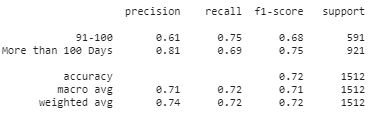